<a href="https://colab.research.google.com/github/paullo0106/prophet_anomaly_detection/blob/master/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fbprophet import Prophet

In [0]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

In [0]:
from datetime import datetime

In [0]:
import fbprophet

In [36]:
fbprophet.__version__

'0.5'

### Prophet
1. ABCCD
2. CCCC


In [0]:
def prophet_fit(df, prophet_model, today_index, lookback_days=None, predict_days=21, alpha=0.95):

    baseline_ts = df['ds'][:today_index]
    baseline_y = df['y'][:today_index]
    if not lookback_days:
        print('Use the data from {} to {} ({} days)'.format(df['ds'][0], df['ds'][today_index-1], today_index))
    else:
        baseline_ts = df['ds'][today_index-lookback_days:today_index]
        baseline_y = df.y[today_index-lookback_days:today_index]
        print('Use the data from {} to {} ({} days)'.format(df['ds'][today_index-lookback_days], 
                                                    df['ds'][today_index-1], lookback_days))    
    print('Predict {} to {} ({} days)'.format(df['ds'][today_index], df['ds'][today_index+predict_days-1], predict_days))

    prophet_model.fit(pd.DataFrame({'ds': baseline_ts.values, 
                                     'y': baseline_y.values}))
    future = prophet_model.make_future_dataframe(periods=predict_days)
    forecast = prophet_model.predict(future)
    fig = prophet_model.plot(forecast)
    return fig, forecast, prophet_model


def prophet_plot(df, fig, forecast, today_index, lookback_days=None, predict_days=21, outliers=list()):

    ax = fig.get_axes()[0]

    start = 0
    end = today_index+predict_days
    x_pydatetime = df['ds'].dt.to_pydatetime()
    ax.plot(x_pydatetime[start:end], 
            df.y[start:end],
            color='orange', label='Actual')
    print('actual: {} to {}'.format(df['ds'][start], df['ds'][end-1]))
    
    # plot each outlier 
    for outlier in outliers:
        ax.scatter(outlier[0], outlier[1], color='red', label='Anomaly')
        ax.text(outlier[0], outlier[1], str(outlier[0])[:10], color='red') # annotate the date

    if len(outliers) == 0:
        print('No outliers')

    # highlight baseline time frame
    if lookback_days:
        start = today_index-lookback_days
    print('baseline: {} to {}'.format(x_pydatetime[start], x_pydatetime[today_index]))    
    ax.axvspan(x_pydatetime[start], 
               x_pydatetime[today_index], 
               color=sns.xkcd_rgb['grey'], 
               alpha=0.2)
    # annotate the areas
    ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
    
    print((start+today_index)/2, (today_index+predict_days)/2)
    ax.text(x_pydatetime[int((start+today_index)/2)], ymin + (ymax-ymin)/20, 'Baseline area') 
    ax.text(x_pydatetime[int((today_index*2+predict_days)/2)], ymin + (ymax-ymin)/20, 'Prediction area')
    
    # re-organize the legend
    patch1 = mpatches.Patch(color='red', label='Anomaly')
    patch2 = mpatches.Patch(color='orange', label='Actual')
    patch3 = mpatches.Patch(color='skyblue', label='Predict and interval')
    patch4 = mpatches.Patch(color='grey', label='Baseline area')
    plt.legend(handles=[patch1, patch2, patch3, patch4])   
        
    plt.show()

In [0]:
def get_outliers(df, forecast, today_index, predict_days=14):
    
    df_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(predict_days)
    df_pred.index = df_pred['ds'].dt.to_pydatetime()
    df_pred.columns = ['ds', 'preds', 'lower_y', 'upper_y']
    df_pred['actual'] = df['y'][today_index: today_index+predict_days].values
    
    outlier_index = list()
    outliers = list()
    for i in range(df_pred.shape[0]):
        actual_value = df_pred['actual'][i]
        if actual_value < df_pred['lower_y'][i] or actual_value > df_pred['upper_y'][i]:
            outlier_index += [i]
            
            outlier_rate = abs(actual_value - df_pred['preds'][i]) / ((df_pred['upper_y'][i] - df_pred['lower_y'][i]) / 2.)
            
            print('=====')
            #print('{}% outlier rate'.format(round(outlier_rate/ 100., 2)))
            print('actual value {} fall outside of the prediction interval'.format(actual_value))
            print('interval: {} to {}'.format(df_pred['lower_y'][i], df_pred['upper_y'][i]))
            print('Date: {}'.format(str(df_pred.index[i])[:10]))

            outliers.append((df_pred.index[i], actual_value))

    return outliers, df_pred

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv')

In [40]:
df.shape

(2905, 2)

In [41]:
df.dtypes

ds     object
y     float64
dtype: object

In [0]:
df.ds = pd.to_datetime(df.ds)
df.index = df.ds

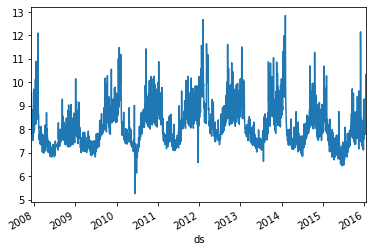

In [43]:
df.y.plot()
plt.show()

In [0]:
# use specific time frame 
df = df[(df.ds >= datetime(2011, 1, 1)) & (df.ds < datetime(2013, 3, 1))]

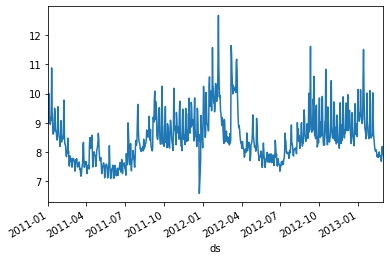

In [45]:
df.y.plot()
plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2011-02-18 00:00:00
Use the data from 2011-01-01 00:00:00 to 2011-02-17 00:00:00 (48 days)
Predict 2011-02-18 00:00:00 to 2011-03-03 00:00:00 (14 days)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====
actual value 7.51969240411654 fall outside of the prediction interval
interval: 7.6508281219144925 to 8.64815855522574
Date: 2011-02-20
=====
actual value 7.750614732770409 fall outside of the prediction interval
interval: 6.630972466150975 to 7.71313428882723
Date: 2011-03-01
actual: 2011-01-01 00:00:00 to 2011-03-03 00:00:00
baseline: 2011-01-01 00:00:00 to 2011-02-18 00:00:00
24.0 31.0


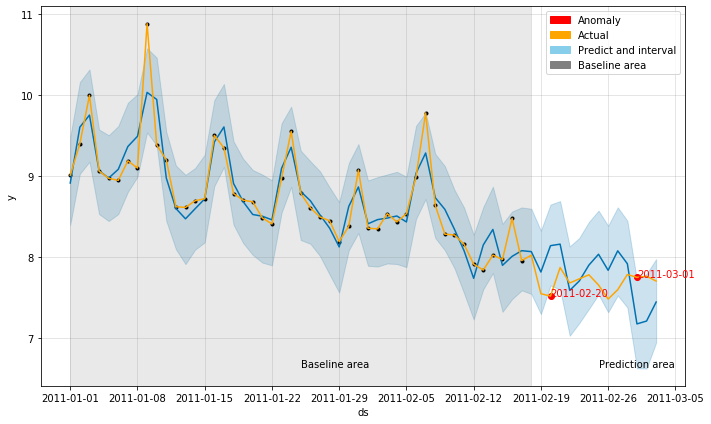

In [61]:
alpha=0.98

model = Prophet(interval_width=alpha, 
                     #monthly_seasonality=True,
                     yearly_seasonality=False, 
                     weekly_seasonality=False, #holidays=us_public_holidays, 
                     changepoint_prior_scale=0.5)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

today_index = 48
print(df.index[today_index])

predict_n = 14

fig, forecast, model = prophet_fit(df, model, today_index, predict_days=predict_n, alpha=0.98)

outliers, df_pred = get_outliers(df, forecast.tail(predict_n), today_index, predict_days=predict_n)

prophet_plot(df, fig, forecast, today_index, predict_days=predict_n, outliers=outliers)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2011-02-18 00:00:00
Use the data from 2011-01-01 00:00:00 to 2011-02-17 00:00:00 (48 days)
Predict 2011-02-18 00:00:00 to 2011-03-03 00:00:00 (14 days)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====
actual value 7.51969240411654 fall outside of the prediction interval
interval: 7.632684599246276 to 8.643338229601763
Date: 2011-02-20
=====
actual value 7.5989004568714105 fall outside of the prediction interval
interval: 7.603498593665647 to 8.568410707304366
Date: 2011-02-27
=====
actual value 7.750614732770409 fall outside of the prediction interval
interval: 6.668084879776731 to 7.729659951034837
Date: 2011-03-01
=====
actual value 7.764720544771481 fall outside of the prediction interval
interval: 6.687866886289384 to 7.685134245631
Date: 2011-03-02
actual: 2011-01-01 00:00:00 to 2011-03-03 00:00:00
baseline: 2011-01-01 00:00:00 to 2011-02-18 00:00:00
24.0 31.0


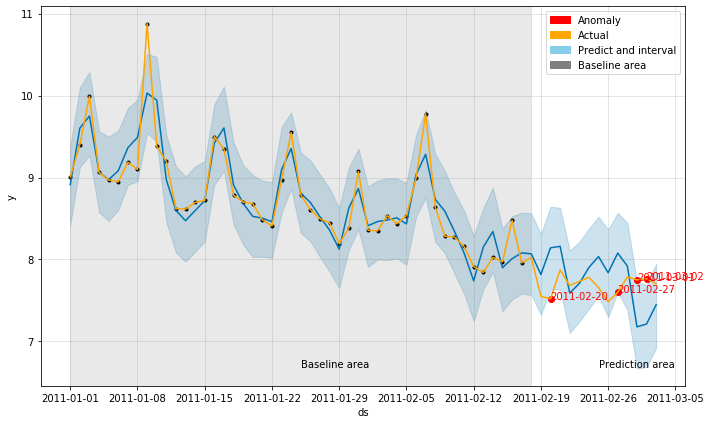

In [62]:
alpha=0.97

model = Prophet(interval_width=alpha, 
                     #monthly_seasonality=True,
                     yearly_seasonality=False, 
                     weekly_seasonality=False, #holidays=us_public_holidays, 
                     changepoint_prior_scale=0.5)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

today_index = 48
print(df.index[today_index])

predict_n = 14

fig, forecast, model = prophet_fit(df, model, today_index, predict_days=predict_n, alpha=0.98)

outliers, df_pred = get_outliers(df, forecast.tail(predict_n), today_index, predict_days=predict_n)

prophet_plot(df, fig, forecast, today_index, predict_days=predict_n, outliers=outliers)

In [22]:
print('Predictions')
print(df_pred.head())
df_outlier = df_pred[(df_pred.actual > df_pred.upper_y) | (df_pred.actual < df_pred.lower_y)]
print('Outliers')
print(df_outlier.head())

Predictions
                   ds     preds   lower_y   upper_y    actual
2011-02-18 2011-02-18  8.068044  7.531397  8.597852  8.023552
2011-02-19 2011-02-19  7.816672  7.292504  8.356813  7.549083
2011-02-20 2011-02-20  8.141675  7.542307  8.651881  7.519692
2011-02-21 2011-02-21  8.160174  7.614976  8.697620  7.871693
2011-02-22 2011-02-22  7.590085  7.078090  8.093581  7.681560
Outliers
                   ds     preds   lower_y   upper_y    actual
2011-02-20 2011-02-20  8.141675  7.542307  8.651881  7.519692
2011-03-01 2011-03-01  7.177063  6.630177  7.742846  7.750615
2011-03-02 2011-03-02  7.212301  6.665520  7.756678  7.764721


In [63]:
print('Predictions')
print(df_pred.head())
df_outlier = df_pred[(df_pred.actual > df_pred.upper_y) | (df_pred.actual < df_pred.lower_y)]
print('Outliers')
print(df_outlier.head())

Predictions
                   ds     preds   lower_y   upper_y    actual
2011-02-18 2011-02-18  8.068044  7.568201  8.561446  8.023552
2011-02-19 2011-02-19  7.816672  7.325318  8.312356  7.549083
2011-02-20 2011-02-20  8.141675  7.632685  8.643338  7.519692
2011-02-21 2011-02-21  8.160174  7.633842  8.631858  7.871693
2011-02-22 2011-02-22  7.590085  7.101720  8.108677  7.681560
Outliers
                   ds     preds   lower_y   upper_y    actual
2011-02-20 2011-02-20  8.141675  7.632685  8.643338  7.519692
2011-02-27 2011-02-27  8.077978  7.603499  8.568411  7.598900
2011-03-01 2011-03-01  7.177063  6.668085  7.729660  7.750615
2011-03-02 2011-03-02  7.212301  6.687867  7.685134  7.764721


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2011-02-18 00:00:00
Use the data from 2011-01-14 00:00:00 to 2011-02-17 00:00:00 (35 days)
Predict 2011-02-18 00:00:00 to 2011-03-03 00:00:00 (14 days)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====
actual value 8.02355239240435 fall outside of the prediction interval
interval: 6.446558598200228 to 6.932023087038858
Date: 2011-02-18
=====
actual value 7.549082710812289 fall outside of the prediction interval
interval: 4.2124155887773576 to 4.9516594541919
Date: 2011-02-19
=====
actual value 7.51969240411654 fall outside of the prediction interval
interval: 2.6722755533653926 to 3.8028551808607114
Date: 2011-02-20
=====
actual value 7.871692664323651 fall outside of the prediction interval
interval: 1.9801238075045795 to 3.6414204402211063
Date: 2011-02-21
=====
actual value 7.68156036255954 fall outside of the prediction interval
interval: 1.479820615724158 to 3.687966402129424
Date: 2011-02-22
=====
actual value 7.732369222284389 fall outside of the prediction interval
interval: 1.7810469279370496 to 4.667029628704743
Date: 2011-02-23
=====
actual value 7.7823903355874595 fall outside of the prediction interval
interval: 1.3657348858240386 to 4.922863286038325
Date: 2011-02

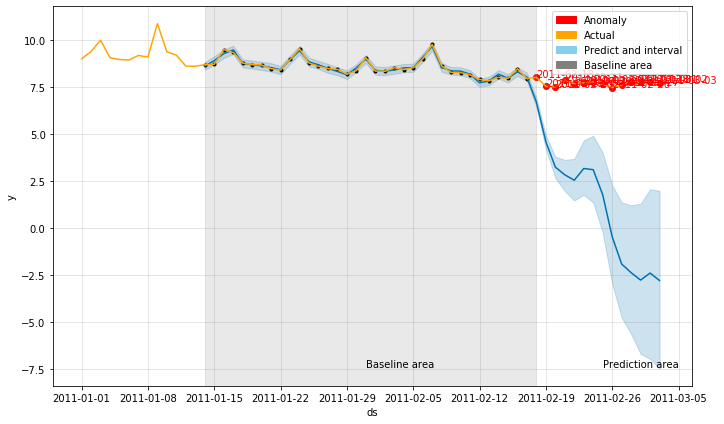

In [64]:
alpha=0.98

model = Prophet(interval_width=alpha, 
                     yearly_seasonality=False, 
                     weekly_seasonality=False, 
                     changepoint_prior_scale=0.5)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

today_index = 48
print(df.index[today_index])

predict_n = 14
lookback_n = 35

fig, forecast, model = prophet_fit(df, model, today_index, lookback_days=lookback_n, 
                                   predict_days=predict_n, alpha=alpha)

outliers, df_pred = get_outliers(df, forecast, today_index, predict_days=predict_n)

prophet_plot(df, fig, forecast, today_index, lookback_days=lookback_n, 
             predict_days=predict_n, outliers=outliers)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2011-02-18 00:00:00
Use the data from 2011-01-14 00:00:00 to 2011-02-17 00:00:00 (35 days)
Predict 2011-02-18 00:00:00 to 2011-03-03 00:00:00 (14 days)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====
actual value 7.7823903355874595 fall outside of the prediction interval
interval: 7.862344279641921 to 8.578395946091442
Date: 2011-02-24
=====
actual value 7.6563371664301805 fall outside of the prediction interval
interval: 7.84098007982512 to 8.500910322501898
Date: 2011-02-25
=====
actual value 7.750614732770409 fall outside of the prediction interval
interval: 6.882261692679702 to 7.557999010192004
Date: 2011-03-01
actual: 2011-01-01 00:00:00 to 2011-03-03 00:00:00
baseline: 2011-01-14 00:00:00 to 2011-02-18 00:00:00
30.5 31.0


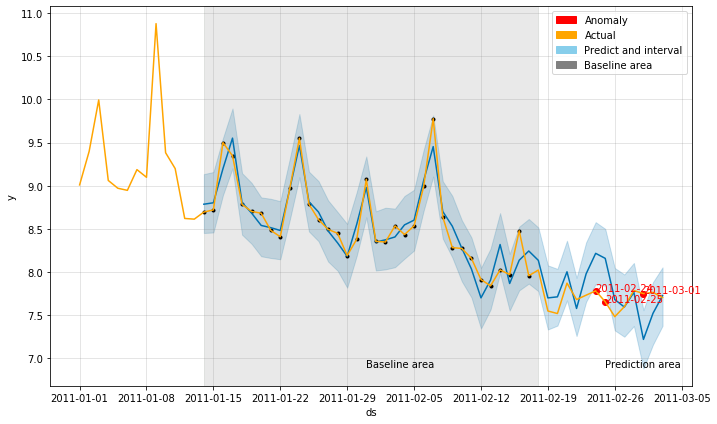

In [65]:
# test with lower changepoint_prior_scale
alpha=0.98

model = Prophet(interval_width=alpha, 
                     yearly_seasonality=False, 
                     weekly_seasonality=False, 
                     changepoint_prior_scale=0.1)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

today_index = 48
print(df.index[today_index])

predict_n = 14
lookback_n = 35

fig, forecast, model = prophet_fit(df, model, today_index, lookback_days=lookback_n, 
                                   predict_days=predict_n, alpha=alpha)

outliers, df_pred = get_outliers(df, 
                                 forecast,
                                 today_index, predict_days=predict_n)

prophet_plot(df, fig, forecast, today_index, lookback_days=lookback_n, 
             predict_days=predict_n, outliers=outliers)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.


2011-02-18 00:00:00
Use the data from 2011-01-21 00:00:00 to 2011-02-17 00:00:00 (28 days)
Predict 2011-02-18 00:00:00 to 2011-03-03 00:00:00 (14 days)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====
actual value 7.764720544771481 fall outside of the prediction interval
interval: 6.555603184251755 to 7.714684112251479
Date: 2011-03-02
=====
actual value 7.70481192293259 fall outside of the prediction interval
interval: 6.238519554094908 to 7.701970125109477
Date: 2011-03-03
actual: 2011-01-01 00:00:00 to 2011-03-03 00:00:00
baseline: 2011-01-21 00:00:00 to 2011-02-18 00:00:00
34.0 31.0


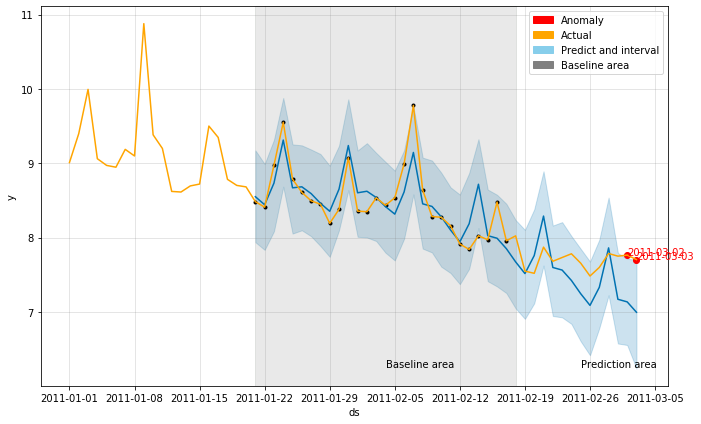

In [66]:
# changepoint_prior_scale: 0.1
# no monthly trend
alpha=0.98

model = Prophet(interval_width=alpha, 
                     yearly_seasonality=False, 
                     weekly_seasonality=False, 
                     changepoint_prior_scale=0.1)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

today_index = 48
print(df.index[today_index])

predict_n = 14
lookback_n = 28

fig, forecast, model = prophet_fit(df, model, today_index, lookback_days=lookback_n, 
                                   predict_days=predict_n, alpha=alpha)

outliers, df_pred = get_outliers(df, 
                                 forecast,
                                 today_index, predict_days=predict_n)

prophet_plot(df, fig, forecast, today_index, lookback_days=lookback_n, 
             predict_days=predict_n, outliers=outliers)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2011-03-19 00:00:00
Use the data from 2011-02-12 00:00:00 to 2011-03-18 00:00:00 (35 days)
Predict 2011-03-19 00:00:00 to 2011-04-08 00:00:00 (21 days)
=====
actual value 7.4139702901904405 fall outside of the prediction interval
interval: 7.478619277555392 to 7.8451763523273055
Date: 2011-03-21
=====
actual value 8.269756947532981 fall outside of the prediction interval
interval: 7.19554782928039 to 7.572739052144498
Date: 2011-03-24
=====
actual value 8.33134542484572 fall outside of the prediction interval
interval: 7.05825209886354 to 7.44612225995532
Date: 2011-03-25
=====
actual value 7.7844732357364705 fall outside of the prediction interval
interval: 6.8869782273721345 to 7.286139394247777
Date: 2011-03-26
=====
actual value 7.597396320212789 fall outside of the prediction interval
interval: 7.655261294266907 to 8.15185799206856
Date: 2011-03-30
=====
actual value 7.4283331941908095 fall outside of the prediction interval
interval: 7.498463500495542 to 8.148616200638259
Date: 2

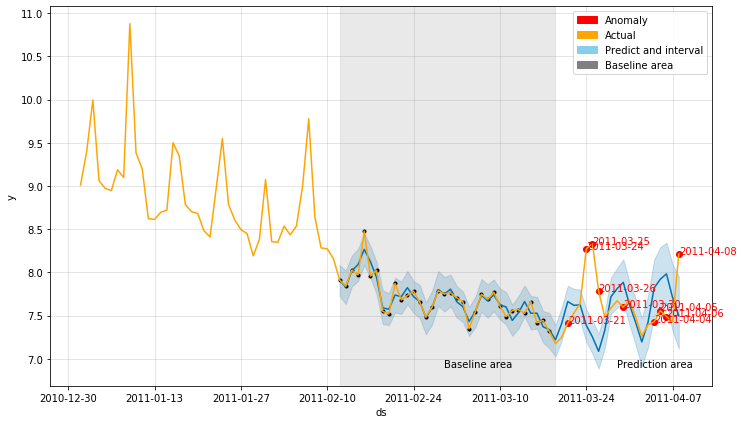

In [71]:
# different timeframe segments

alpha = 0.98
model = Prophet(interval_width=alpha, 
                     yearly_seasonality=False, 
                     weekly_seasonality=False, #holidays=us_public_holidays, 
                     changepoint_prior_scale=0.5)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

today_index = 77
print(df.index[today_index])  # print cutoff date

predict_n = 21
lookback_n = 35

fig, forecast, model = prophet_fit(df, model, today_index, lookback_days=lookback_n, predict_days=predict_n, alpha=alpha)

outliers, df_pred = get_outliers(df, forecast, today_index, predict_days=predict_n)

prophet_plot(df, fig, forecast, today_index, lookback_days=lookback_n, predict_days=predict_n, outliers=outliers)

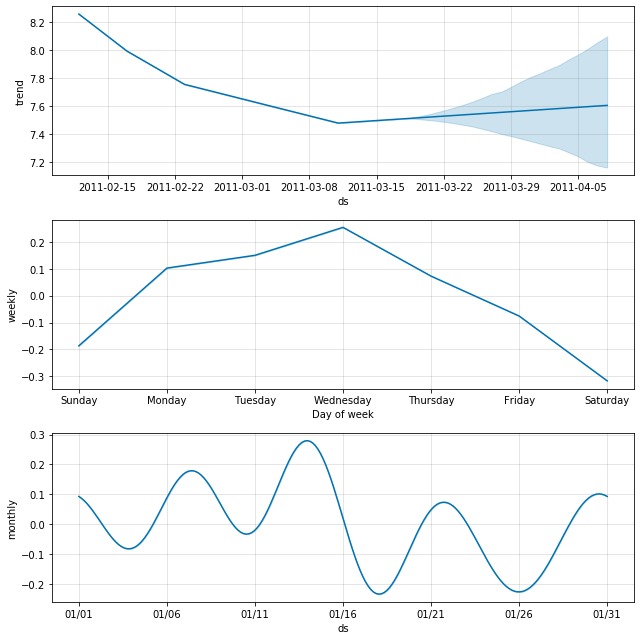

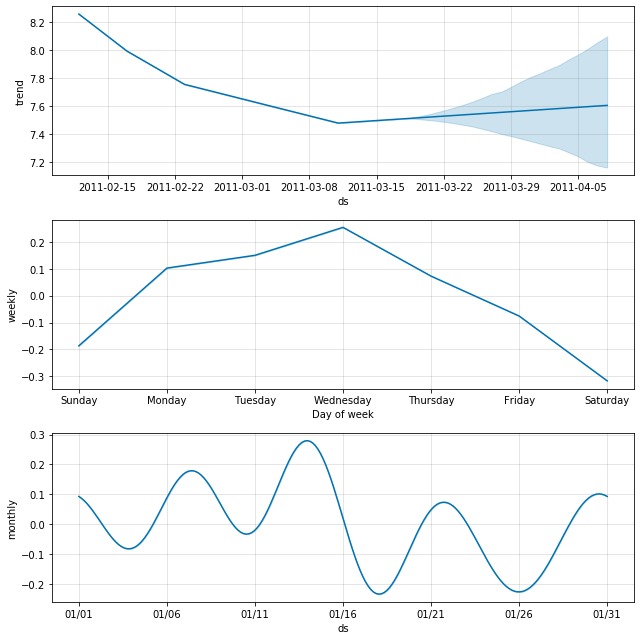

In [0]:
model.plot_components(forecast)